In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
%matplotlib inline

In [2]:
import lasagne
from lasagne.layers import *

In [3]:
input_D=T.matrix("Discriminator")
input_G=T.matrix("Generator")

In [4]:
input_shape=[100,2]
input_G_shape=[100,5]

In [5]:
gl1=InputLayer(shape=input_G_shape,input_var=input_G)
gl2=DenseLayer(gl1,num_units=20,nonlinearity=lasagne.nonlinearities.rectify)
gl3=DenseLayer(gl2,num_units=8,nonlinearity=lasagne.nonlinearities.rectify)
gl_out=DenseLayer(gl3,num_units=2,nonlinearity=lasagne.nonlinearities.linear)

y_g_pred=lasagne.layers.get_output(gl_out)

weights_g=lasagne.layers.get_all_params(gl_out)


In [6]:
dl1T=InputLayer(shape=input_shape,input_var=input_D)
dl2T=DenseLayer(dl1T,num_units=5,nonlinearity=lasagne.nonlinearities.rectify)
dl3T=DenseLayer(dl2T,num_units=5,nonlinearity=lasagne.nonlinearities.leaky_rectify)
dlT_out=DenseLayer(dl3T,num_units=1,nonlinearity=lasagne.nonlinearities.sigmoid)

dlg_input=y_g_pred.reshape(shape=input_shape)

dl1G=InputLayer(shape=input_shape,input_var=dlg_input)
dl2G=DenseLayer(dl1G,num_units=5,nonlinearity=lasagne.nonlinearities.rectify,W=dl2T.W,b=dl2T.b)
dl3G=DenseLayer(dl2G,num_units=5,nonlinearity=lasagne.nonlinearities.leaky_rectify,W=dl3T.W,b=dl3T.b)
dlG_out=DenseLayer(dl3G,num_units=1,nonlinearity=lasagne.nonlinearities.sigmoid,W=dlT_out.W,b=dlT_out.b)

y_dG_pred=lasagne.layers.get_output(dlG_out)
y_dT_pred=lasagne.layers.get_output(dlT_out)


weights_d=lasagne.layers.get_all_params(dlT_out)

In [7]:
loss_d=-(T.log(y_dT_pred+1e-9)+T.log(1-y_dG_pred+1e-9)).mean()
accuracy_d=((y_dT_pred>0.5).sum()+(y_dG_pred<0.5).sum())/(y_dG_pred.shape[0]+y_dT_pred.shape[0])

updates_sgd_d=lasagne.updates.adadelta(loss_d,weights_d,learning_rate=0.3)
#D_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
#updates_sgd_d = lasagne.updates.nesterov_momentum(loss_d, weights_d, learning_rate=D_lr, momentum=0.6)
    
train_fun_d=theano.function([input_D,input_G],[loss_d,accuracy_d],updates=updates_sgd_d)

accuracy_fun_d=theano.function([input_D,input_G],accuracy_d)

loss_g=-(T.log(y_dG_pred+1e-9)).mean()

accuracy_g=(y_dG_pred>0.5).sum()/(y_dG_pred.shape[0])
updates_sgd_g=lasagne.updates.adadelta(loss_g,weights_g,learning_rate=0.3)
#G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
#updates_sgd_g = lasagne.updates.nesterov_momentum(loss_g, weights_g, learning_rate=G_lr, momentum=0.6)
    
train_fun_g=theano.function([input_G],[loss_g,accuracy_g],updates=updates_sgd_g)
accuracy_fun_g=theano.function([input_G],accuracy_g)

In [8]:
def make_normal(center,mu,sz):
    mu+=(np.random.random()-0.5)*0.02
    center+=(np.random.random()-0.5)*0.2
    return np.random.normal(center,mu,size=sz)

In [9]:
def make_noise(sz):
    #return (np.linspace(-5.0,5.0,sz[0])+np.random.random(sz[0])*0.01).reshape(sz)
    return np.random.random(size=sz)

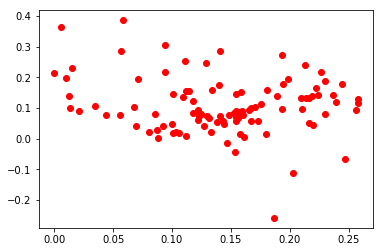

In [10]:
p=y_g_pred.eval({input_G:make_noise(input_G_shape)}).reshape(input_shape)
plt.plot([i[0] for i in p],[i[1] for i in p],'ro')
plt.show()

In [11]:
center=5
mu=1

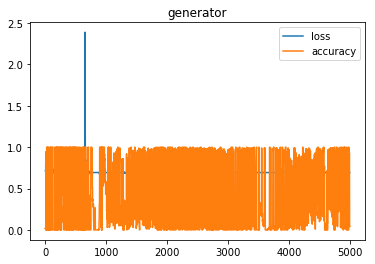

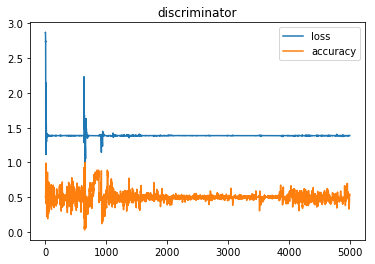

In [12]:
num_ep=10000
losses=[]
accuracies=[]
losses1=[]
accuracies1=[]
DD=5
GG=5
for i in range(num_ep):
    for k in range(DD):
        inptD=make_normal(center,mu,sz=input_shape)
        input_noiseG=make_noise(sz=input_G_shape)
        loss1,accuracy1=train_fun_d(inptD,input_noiseG)
        #if accuracy1>0.8 and DD:
        #    DD-=1
        #    GG+=1
        #if accuracy1<0.2 and GG:
        #    GG-=1
        #    DD+=1
        if i%10==0:
            losses1.append(loss1)
            accuracies1.append(accuracy1)
    for k in range(GG):
        loss,accuracy=train_fun_g(input_noiseG)
        if i%10==0:
            losses.append(loss)
            accuracies.append(accuracy)
        #if accuracy>0.8 and GG:
        #    GG-=1
        #    DD+=1
        #if accuracy<0.2 and DD:
        #    DD-=1
        #    GG+=1
    #print("epoch={}".format(i))
#plt.subplot(211)
plt.title('generator')
plt.plot(losses,label="loss")
plt.plot(accuracies,label='accuracy')
plt.legend()
plt.show()
#plt.subplot(212)
plt.title('discriminator')
plt.plot(losses1,label="loss")
plt.plot(accuracies1,label='accuracy')
plt.legend()
plt.show()

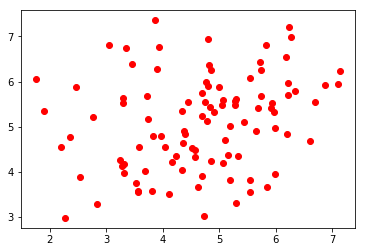

In [13]:
#print(DD,GG)
p=y_g_pred.eval({input_G:make_noise(input_G_shape)}).reshape(input_shape)
#plt.axis([0,20,0,20])
plt.plot([i[0] for i in p],[i[1] for i in p],'ro')
plt.show()

In [14]:
#print(y_dT_pred.eval({input_D:make_noise(sz=[100,N,2])})[0])
print(y_dT_pred.eval({input_D:make_normal(5,1,sz=input_shape)})[0])
print(y_dG_pred.eval({input_G:make_noise(sz=input_G_shape)})[0])
print(accuracy_fun_d(make_normal(5,1,sz=input_shape),make_noise(sz=input_G_shape)))
#print(accuracy_fun_d(make_normal(15,1,sz=[100,N,2]),make_noise(sz=[100,1])))
#print(accuracy_fun_d(make_noise(sz=[100,N,2]),make_noise(sz=[100,1,1])))
#print(accuracy_fun_d(make_noise(sz=[100,N,2]),make_noise(sz=[100,1,1])))


[ 0.50375837]
[ 0.49879644]
0.43


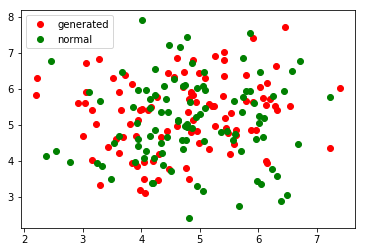

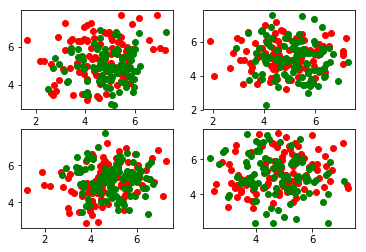

In [15]:
p=y_g_pred.eval({input_G:make_noise(input_G_shape)}).reshape(input_shape)
p1=make_normal(5,1,input_shape)
plt.plot([i[0] for i in p],[i[1] for i in p],'ro',label='generated')
plt.plot([i[0] for i in p1],[i[1] for i in p1],'go',label='normal')
plt.legend()
plt.show()
plt.subplot(221)
p=y_g_pred.eval({input_G:make_noise(input_G_shape)}).reshape(input_shape)
p1=make_normal(5,1,input_shape)
plt.plot([i[0] for i in p],[i[1] for i in p],'ro')
plt.plot([i[0] for i in p1],[i[1] for i in p1],'go')
plt.subplot(222)
p=y_g_pred.eval({input_G:make_noise(input_G_shape)}).reshape(input_shape)
p1=make_normal(5,1,input_shape)
plt.plot([i[0] for i in p],[i[1] for i in p],'ro')
plt.plot([i[0] for i in p1],[i[1] for i in p1],'go')
plt.subplot(223)
p=y_g_pred.eval({input_G:make_noise(input_G_shape)}).reshape(input_shape)
p1=make_normal(5,1,input_shape)
plt.plot([i[0] for i in p],[i[1] for i in p],'ro')
plt.plot([i[0] for i in p1],[i[1] for i in p1],'go')
plt.subplot(224)
p=y_g_pred.eval({input_G:make_noise(input_G_shape)}).reshape(input_shape)
p1=make_normal(5,1,input_shape)
plt.plot([i[0] for i in p],[i[1] for i in p],'ro')
plt.plot([i[0] for i in p1],[i[1] for i in p1],'go')
plt.show()

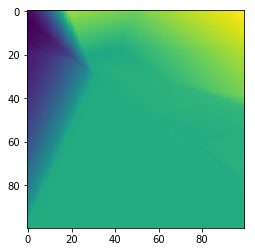

In [16]:
import matplotlib.image as mpimg

pointsX=np.linspace(-5,15,100)
pointsY=np.linspace(-5,15,100)
img=[]
for i in range(100):
    Zs=y_dT_pred.eval({input_D:[[pointsX[i],q]for q in pointsY]})
    Zs=[q[0] for q in Zs]
    img.append([q for q in Zs])
img=np.array(img)
plt.imshow(img)

It is probability of each point to be from normal distribution, calculated by discriminator. It is uniform now , because discriminator cannot classify wheter point is generated or not.